# M4 Competition Dataset - Financial Time Series Forecasting
This notebook is made for finance master thesis which explores how different models perform on M4 competition dataset. Results can be used to guide financial analysts and institutions in selecting forecasting models that are better suited for short-term vs long-term planning.

In [34]:
from datasetsforecast.m4 import M4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from data_loading import load_m4_financial
import random
from models import (
    ARIMAModel,
    HoltWintersModel,
    RNNModel,
    LSTMModel,
    XGBoostModel,
    AutoformerModel,
    InformerModel,
    TFTModel
)

ImportError: cannot import name 'AutoformerModel' from 'models.autoformer_model' (/Users/SanteriPentinen/Gradu model/models/autoformer_model.py)

In [3]:
#Testing that torch uses gpu
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

CUDA available: False
Device name: No GPU found


## 1. M4 Dataset importing
To load M4 Dataset i will use 'datasetforecast' library

In [4]:
#Uncomment if data is not yet downloaded
#load_m4_financial(data_dir='./data')

In [5]:
df_info = pd.read_csv("data/m4/datasets/M4-info.csv")
df_train_daily = pd.read_csv("data/m4/datasets/Daily-train.csv")

In [6]:
df_info_finance = df_info[df_info['category'] == 'Finance']
df_info_finance

,M4id,category,Frequency,Horizon,SP,StartingDate
15245,Y15246,Finance,1,6,Yearly,01-01-81 12:00
15246,Y15247,Finance,1,6,Yearly,01-01-83 12:00
15247,Y15248,Finance,1,6,Yearly,01-01-94 12:00
15248,Y15249,Finance,1,6,Yearly,01-01-94 12:00
15249,Y15250,Finance,1,6,Yearly,01-01-93 12:00
...,...,...,...,...,...,...
98948,D3590,Finance,1,14,Daily,30-03-01 12:00
98949,D3591,Finance,1,14,Daily,30-03-01 12:00
98950,D3592,Finance,1,14,Daily,30-03-01 12:00
98951,D3593,Finance,1,14,Daily,30-03-01 12:00


In [7]:
df_train_daily_finance = df_train_daily[df_train_daily['V1'].isin(df_info_finance['M4id'])]
df_train_daily_finance = df_train_daily_finance.merge(
    df_info_finance[['M4id', 'StartingDate']],
    left_on='V1',
    right_on='M4id',
    how='left'
)
df_train_daily_finance.drop(columns='M4id', inplace=True)


In [8]:
df_train_daily_finance

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V9912,V9913,V9914,V9915,V9916,V9917,V9918,V9919,V9920,StartingDate
0,D2036,2785.000000,2780.300000,2780.300000,2780.300000,2780.100000,2785.00000,2777.200000,2778.30000,2782.170000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-04-05 12:00
1,D2037,1398.590000,1373.010000,1359.540000,1337.160000,1366.730000,1356.70000,1353.430000,1377.93000,1382.230000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04-01-99 12:00
2,D2038,3560.000000,3530.000000,3520.000000,3510.000000,3500.000000,3490.00000,3460.000000,3450.00000,3440.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16-05-03 12:00
3,D2039,1821.000000,1806.000000,1792.000000,1778.000000,1764.000000,1750.00000,1736.000000,1820.00000,1806.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19-04-00 12:00
4,D2040,4066.542677,4085.371744,3987.976769,3968.892827,4012.677163,4054.60221,3987.194679,3997.11777,3963.263482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21-05-13 12:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,D3590,1244.090000,1217.990000,1130.060000,1165.450000,1240.800000,1214.45000,1215.320000,1286.24000,1332.760000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-03-01 12:00
1555,D3591,11729.200000,11451.400000,10490.400000,10851.400000,11637.100000,11269.70000,11247.700000,12061.60000,12464.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-03-01 12:00
1556,D3592,14823.100000,14481.400000,13306.200000,13720.900000,14662.400000,14232.20000,14174.700000,15134.10000,15632.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-03-01 12:00
1557,D3593,1699.210000,1658.900000,1507.610000,1548.830000,1656.830000,1608.42000,1622.460000,1732.39000,1796.950000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-03-01 12:00


In [9]:
def clean_series(group):
    first_valid = group['Observation'].first_valid_index()
    last_valid = group['Observation'].last_valid_index()
    if first_valid is None or last_valid is None:
        return pd.DataFrame(columns=group.columns)  # all NaNs, return empty
    cleaned = group.loc[first_valid:last_valid].copy()
    cleaned['Observation'] = cleaned['Observation'].ffill()
    return cleaned.dropna(subset=['Observation'])

In [10]:
def df_preprocessing(df):
    df_long = pd.melt(
        df,
        id_vars=['V1', 'StartingDate'],
        var_name='DayIndex',
        value_name='Observation'
    )
    df_long['DayOffset'] = (
        df_long['DayIndex']
        .str.replace('V', '', regex=False)
        .astype(int)
    )
    df_long['Date'] = pd.to_datetime(df_long['StartingDate']) + pd.to_timedelta(df_long['DayOffset'] - 1, unit='D')
    df_long.drop(['DayIndex', 'DayOffset'], axis=1, inplace=True)
    df_long.sort_values(by=['V1', 'Date'], inplace=True)
    df_cleaned = df_long.groupby('V1', group_keys=False).apply(clean_series).reset_index(drop=True)
    time_series_dict = {}
    for series_id, sub_df in df_cleaned.groupby('V1'):
        sub_df = sub_df.set_index('Date').sort_index()
        ts = sub_df['Observation']
        time_series_dict[series_id] = ts
    return time_series_dict

In [11]:
dict_finance_train_daily = df_preprocessing(df_train_daily_finance)

/var/folders/dp/g_9xlnhn1219h1vk_shtj1wm0000gn/T/ipykernel_55594/3264734010.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_long['Date'] = pd.to_datetime(df_long['StartingDate']) + pd.to_timedelta(df_long['DayOffset'] - 1, unit='D')
/var/folders/dp/g_9xlnhn1219h1vk_shtj1wm0000gn/T/ipykernel_55594/3264734010.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_long.groupby('V1', group_keys=False).apply(clean_series).reset_index(drop=True)


In [21]:
length = 0
volatility = 0
ts_returns = 0
ts_count = len(dict_finance_train_daily)
all_returns = []
for x in dict_finance_train_daily:
    length += len(dict_finance_train_daily[x])
    returns = dict_finance_train_daily[x].pct_change().dropna()
    ts_returns += returns.mean()
    volatility += returns.std()
print(f"Average time series length: {round(length/ts_count)} days")
print(f"Average return: {round(ts_returns/ts_count, 3)}")
print(f"Average volatility: {round(volatility/ts_count, 3)}")

Average time series length: 3250 days
Average return: 0.001
Average volatility: 0.021


In [28]:
def display_random_series(data_dict, count=5):
    for x in range(count):
        key = random.choice(list(data_dict.keys()))
        series = data_dict[key]
        returns = series.pct_change().dropna()
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        axs[0].plot(series)
        axs[0].set_title(f"Time Series: {key}")
        axs[0].set_xlabel("Time")
        axs[0].set_ylabel("Value")

        axs[1].hist(returns, bins='auto', edgecolor='black')
        axs[1].set_title("Histogram of Returns")
        axs[1].set_xlabel("Return")
        axs[1].set_ylabel("Frequency")

        plt.tight_layout()
        plt.show()

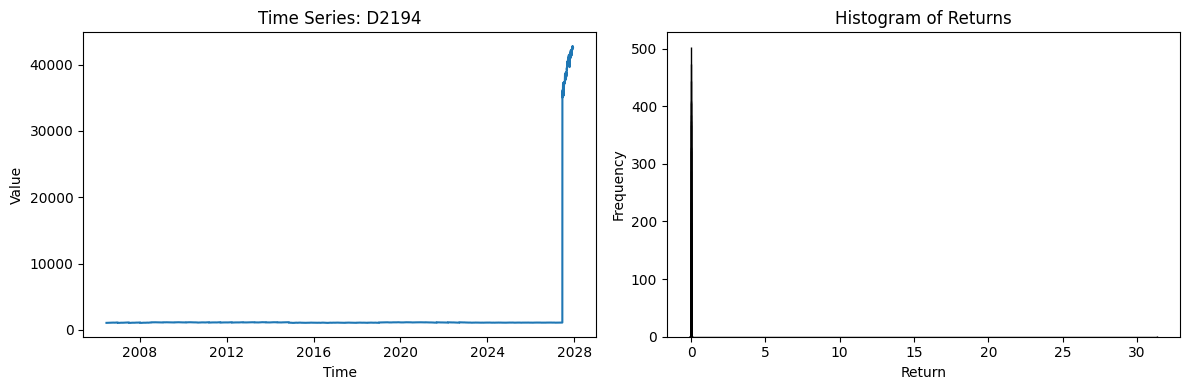

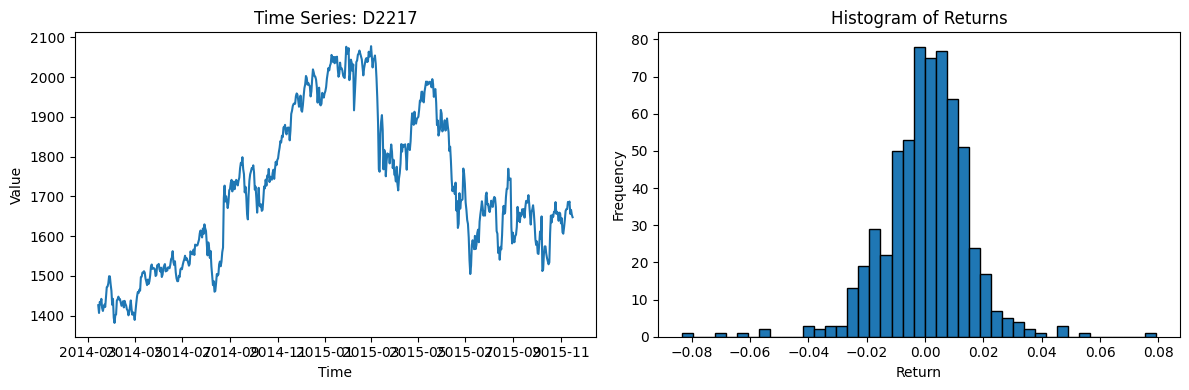

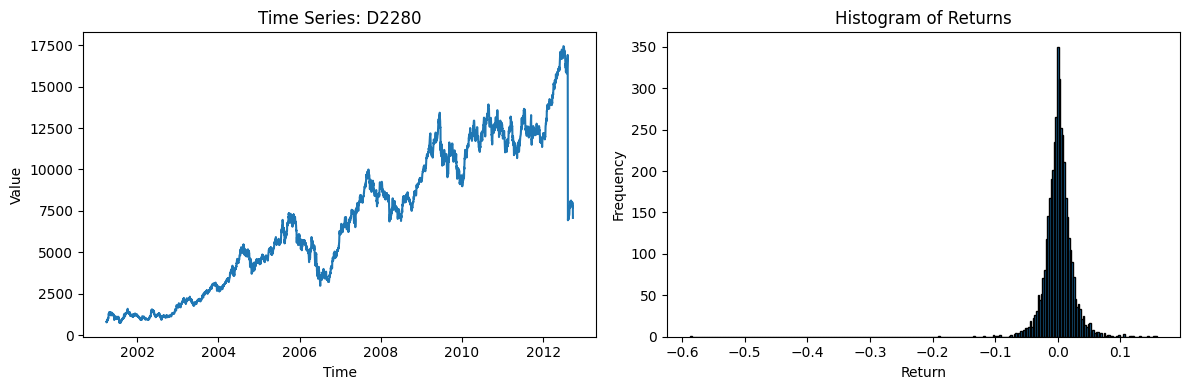

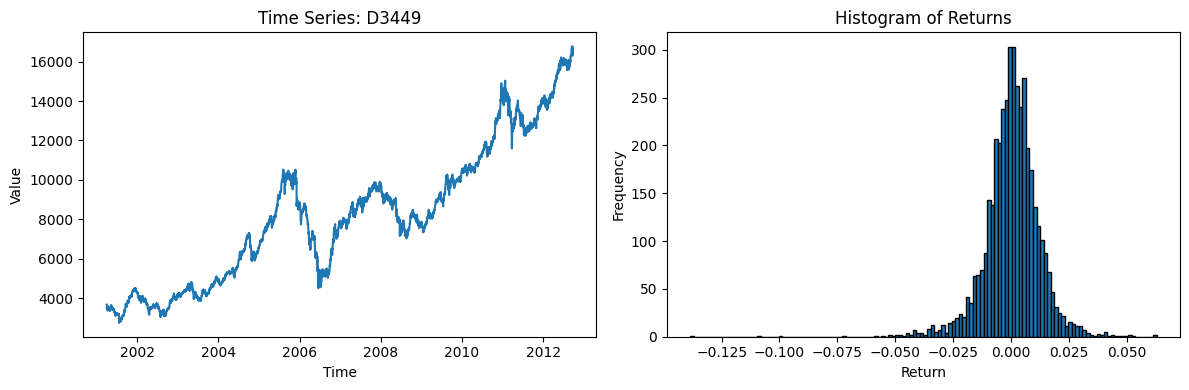

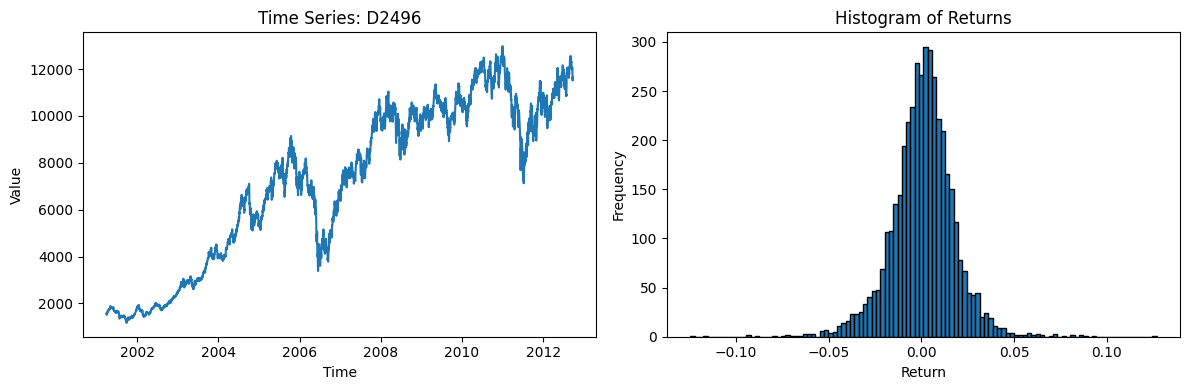

In [29]:
display_random_series(dict_finance_train_daily)